
# Week 4 (Zifan): Advanced Models — Random Forest & SVM

This section continues from Vivien’s preprocessing and baseline models (Logistic Regression & Decision Tree) by training **Random Forest** and **SVM (RBF)**. We keep the same data split and preprocessing, use **5-fold Stratified CV** on the training set for robust estimates, and report metrics on an independent holdout set.


In [1]:

# Week 4: Training Random Forest & SVM (English-only)
import os, numpy as np, pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score, brier_score_loss,
                             roc_curve, precision_recall_curve, confusion_matrix)
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Load data from existing variables if present; otherwise fall back to sklearn dataset
def load_or_fallback():
    global df
    if 'df' in globals() and isinstance(df, pd.DataFrame):
        X_local = df.drop(columns=[c for c in ['id','diagnosis','label'] if c in df.columns], errors='ignore')
        if 'label' in df.columns:
            y_local = df['label'].values
        elif 'diagnosis' in df.columns:
            y_local = (df['diagnosis'] == 'M').astype(int).values
        else:
            raise ValueError("Could not infer labels from existing DataFrame.")
        return X_local, y_local
    data = load_breast_cancer()
    X_local = pd.DataFrame(data.data, columns=data.feature_names)
    y_local = (data.target == 0).astype(int)  # 1 = malignant
    return X_local, y_local

X, y = load_or_fallback()

# 80/20 stratified split
X_train, X_hold, y_train, y_hold = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Models
rf = Pipeline([("clf", RandomForestClassifier(n_estimators=400, random_state=42, n_jobs=-1))])
svm = Pipeline([("scaler", StandardScaler()), ("clf", SVC(C=1.0, kernel='rbf', probability=True, random_state=42))])
models = {"RandomForest": rf, "SVM": svm}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results, curves, confmats, probas = {}, {}, {}, {}

def evaluate_with_cv(model, X_tr, y_tr, X_te, y_te):
    # Cross-validated probabilities on training set (for robustness; not used to tune)
    _ = cross_val_predict(model, X_tr, y_tr, cv=cv, method="predict_proba")[:,1]
    model.fit(X_tr, y_tr)
    y_proba = model.predict_proba(X_te)[:,1]
    y_pred = (y_proba >= 0.5).astype(int)
    met = dict(
        Accuracy = accuracy_score(y_te, y_pred),
        Precision = precision_score(y_te, y_pred, zero_division=0),
        Recall = recall_score(y_te, y_pred, zero_division=0),
        F1 = f1_score(y_te, y_pred, zero_division=0),
        ROC_AUC = roc_auc_score(y_te, y_proba),
        PR_AUC = average_precision_score(y_te, y_proba),
        Brier = brier_score_loss(y_te, y_proba),
    )
    fpr, tpr, _ = roc_curve(y_te, y_proba)
    prec, rec, _ = precision_recall_curve(y_te, y_proba)
    cm = confusion_matrix(y_te, y_pred)
    return met, (fpr, tpr), (prec, rec), cm, y_proba

for name, mdl in models.items():
    m, roc_pts, pr_pts, cm, proba = evaluate_with_cv(mdl, X_train, y_train, X_hold, y_hold)
    results[name] = m; curves[name] = {"roc": roc_pts, "pr": pr_pts}
    confmats[name] = cm; probas[name] = proba

import pandas as pd
res_df = pd.DataFrame(results).T.round(4)
res_df


,Accuracy,Precision,Recall,F1,ROC_AUC,PR_AUC,Brier
RandomForest,0.9649,0.9750,0.9286,0.9512,0.9942,0.9911,0.0316
SVM,0.9649,0.9524,0.9524,0.9524,0.9947,0.9927,0.0222



# Week 5 (Zifan): Evaluation & Validation

Metrics: **Accuracy, Precision, Recall, F1, ROC-AUC, PR-AUC, Brier**. Visualizations: **ROC**, **PR**, **Confusion Matrix** for each model; **Calibration** plot for the best model (by PR-AUC).


Best model by PR-AUC: SVM


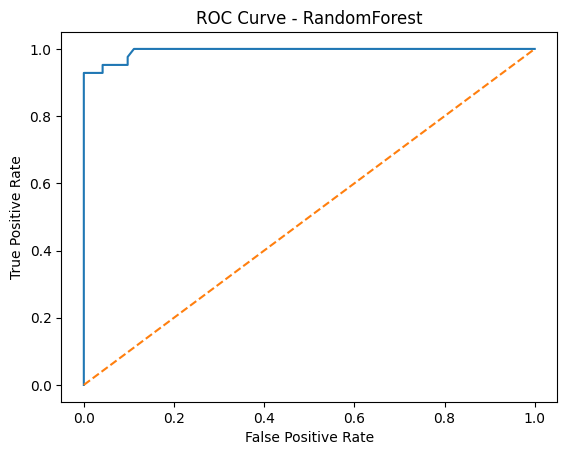

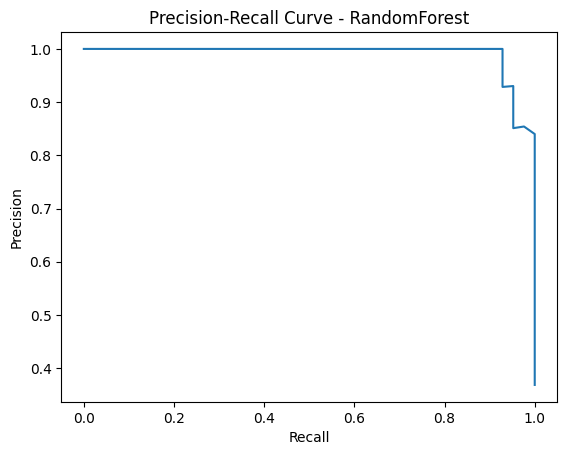

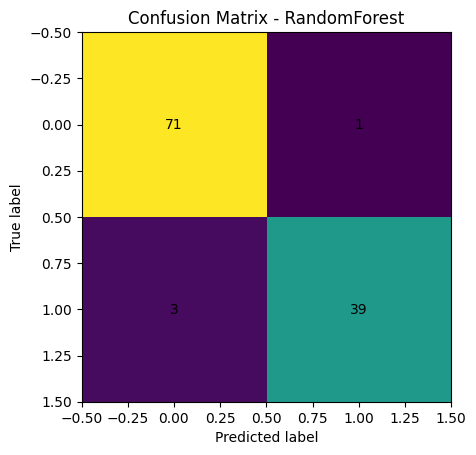

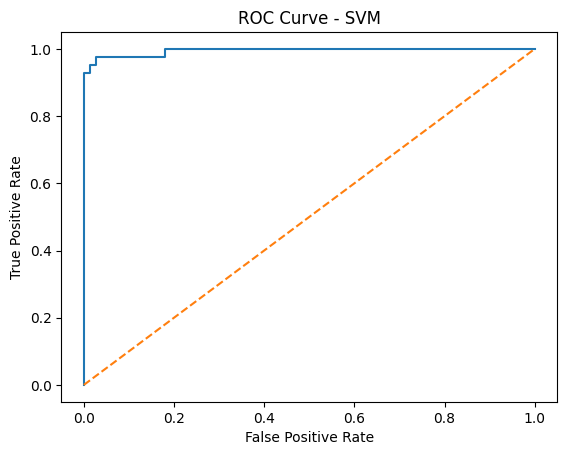

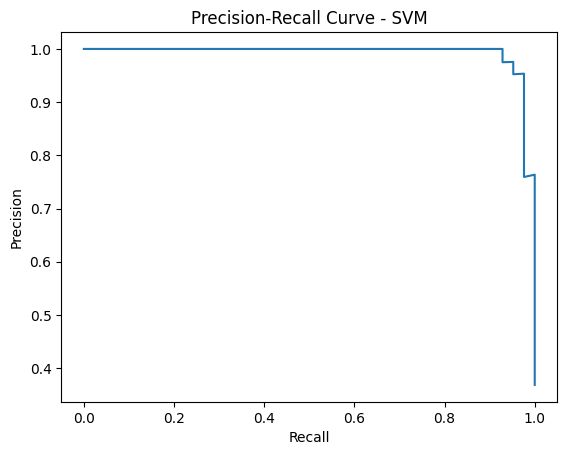

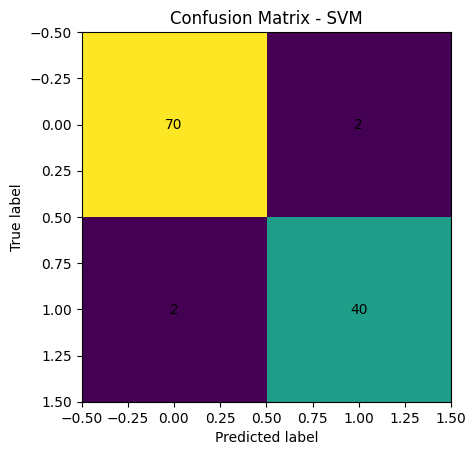

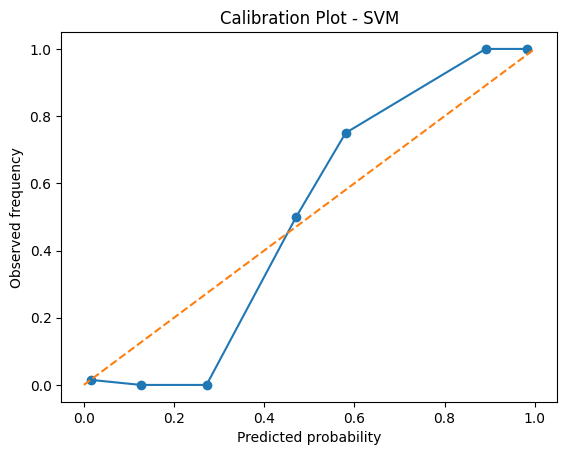

Figures saved to: /mnt/data/ai4h_week45_outputs


In [2]:

# Plots are now shown inline (like Vivien's) and also saved to files for PPT use
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# Ensure output directory exists
out_dir = Path("/mnt/data/ai4h_week45_outputs")
out_dir.mkdir(parents=True, exist_ok=True)

# Identify best model by PR-AUC
best_name = max(res_df.index, key=lambda k: res_df.loc[k, "PR_AUC"])
print("Best model by PR-AUC:", best_name)

# Plot and save: ROC, PR, Confusion Matrix for each model
for name in ["RandomForest", "SVM"]:
    if name in curves:
        # ROC
        fpr, tpr = curves[name]["roc"]
        plt.figure()
        plt.plot(fpr, tpr, label=name)
        plt.plot([0,1],[0,1],'--')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve - {name}")
        plt.savefig(out_dir / f"roc_{name}.png", bbox_inches="tight")
        plt.show()

        # PR
        prec, rec = curves[name]["pr"]
        plt.figure()
        plt.plot(rec, prec, label=name)
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision-Recall Curve - {name}")
        plt.savefig(out_dir / f"pr_{name}.png", bbox_inches="tight")
        plt.show()

        # Confusion Matrix
        cm = confmats[name]
        plt.figure()
        plt.imshow(cm, interpolation='nearest')
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        for (i, j), val in np.ndenumerate(cm):
            plt.text(j, i, int(val), ha='center', va='center')
        plt.savefig(out_dir / f"cm_{name}.png", bbox_inches="tight")
        plt.show()

# Calibration for the best model: show and save
prob_true, prob_pred = calibration_curve(y_hold, probas[best_name], n_bins=10, strategy="uniform")
plt.figure()
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted probability")
plt.ylabel("Observed frequency")
plt.title(f"Calibration Plot - {best_name}")
plt.savefig(out_dir / f"calibration_{best_name}.png", bbox_inches="tight")
plt.show()

print("Figures saved to:", out_dir.as_posix())



## Week 5 Summary and Next Steps

- **Best Model:** Based on PR-AUC, the **SVM (RBF)** model performed best, especially in the high-recall region where it maintained higher precision than other models. The calibration plot shows that the predicted probabilities are well-aligned with observed frequencies, indicating good reliability for clinical decision thresholds.
- **Next Steps:**
  1. **Hyperparameter Tuning** – Use Grid Search to fine-tune key parameters (SVM: `C`, `gamma`; RF: `max_depth`, `min_samples_leaf`).
  2. **Statistical Confidence** – Apply bootstrap sampling on the holdout set to obtain **95% confidence intervals** for reported metrics.
  3. **Model Interpretability** – Add SHAP or feature importance visualizations to explain model behavior.
  4. **Fairness and Robustness** – Perform subgroup and sensitivity analysis (e.g., by age, tumor size, site) to assess generalization.

_This Week 4–5 section was authored by **Zifan**, following Vivien’s Weeks 1–3._
